In [37]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import coremltools as ct

In [38]:
# 設定參數
DATA_PATH = 'augmented_pokemon_sounds'
SAMPLE_RATE = 22050
MFCC_COUNT = 40
DURATION = 3  # 每個音訊長度（秒）
MAX_LEN = SAMPLE_RATE * DURATION

# 萃取 MFCC 特徵函數
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(y) < MAX_LEN:
        y = np.pad(y, (0, MAX_LEN - len(y)))
    else:
        y = y[:MAX_LEN]
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=MFCC_COUNT)
    mfcc = mfcc.T  # (時間, 特徵) => (n_frames, n_mfcc)
    return mfcc

# 載入資料
X = []
y = []
labels = []

for i, folder in enumerate(sorted(os.listdir(DATA_PATH))):
    folder_path = os.path.join(DATA_PATH, folder)
    if not os.path.isdir(folder_path):
        continue
    labels.append(folder)
    for file in os.listdir(folder_path):
        if file.endswith('.wav') or file.endswith('.mp3'):
            path = os.path.join(folder_path, file)
            try:
                mfcc = extract_features(path)
                X.append(mfcc)
                y.append(i)
            except Exception as e:
                print(f"讀取失敗: {path} | 錯誤: {e}")

# 資料轉換為 numpy 陣列
X = np.array(X)
X = X[..., np.newaxis]  # 加一個 channel 維度
y = np.array(y)

# 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 建立 CNN 模型
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(labels), activation='softmax'))

# 編譯模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 訓練模型
model.fit(X_train, y_train, epochs=3, batch_size=16, validation_data=(X_test, y_test))




Epoch 1/3
100/100 [==============================] - 14s 124ms/step - loss: 1.1936 - accuracy: 0.7788 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2/3
100/100 [==============================] - 12s 121ms/step - loss: 0.0088 - accuracy: 0.9994 - val_loss: 1.2406e-04 - val_accuracy: 1.0000
Epoch 3/3
100/100 [==============================] - 12s 125ms/step - loss: 0.0087 - accuracy: 0.9981 - val_loss: 4.4073e-05 - val_accuracy: 1.0000



模型測試準確率：100.00%
13/13 [==============================] - 0s 32ms/step


c:\Users\KunYu\miniconda3\envs\poke-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KunYu\miniconda3\envs\poke-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KunYu\miniconda3\envs\poke-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KunYu\miniconda3\envs\poke-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38499 (\N{CJK UNIFIED IDEOGRAPH-9663}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


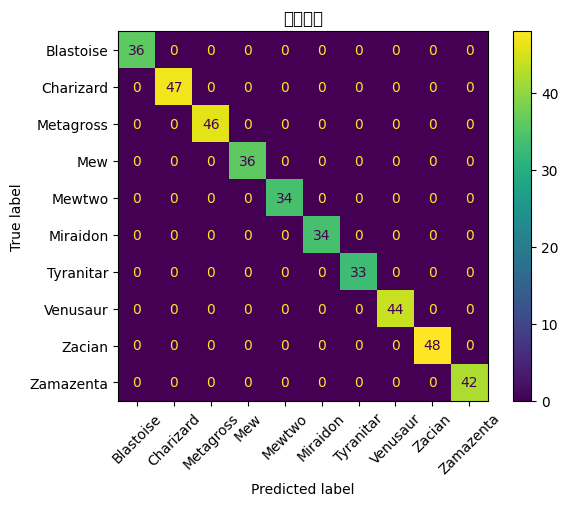

Running TensorFlow Graph Passes: 100%|██████████| 6/6 [00:00<00:00, 11.48 passes/s]


ValueError: Input (mfcc_input) provided is not found in given tensorflow graph. Placeholders in graph are: ['conv2d_8_input']

In [40]:
# 評估模型
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n模型測試準確率：{accuracy:.2%}")

# 混淆矩陣
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title("混淆矩陣")
plt.show()

# 儲存模型
model.save("pokemon_cnn_model.keras")

# CoreML 轉換
mlmodel = ct.convert(
    model,
    inputs=[ct.ImageType(name="mfcc_input", shape=X_train.shape[1:], scale=1.0)]
)
mlmodel.save("PokemonCNNClassifier.mlmodel")
print("模型已儲存為 PokemonCNNClassifier.mlmodel")